# Coding mBasicPH_storage 
## Group 1

We import the basic pachages:

In [149]:
#%run ../stdPackages.ipynb
from pyDbs import *
from IPython.display import Image
figs_path = os.path.join(d['curr'],'Figs')

We create a path to data

In [150]:
path_to_data = os.path.join(d['curr'],'E44_Data.xlsx')
print(path_to_data)

c:\Users\CAAL\OneDrive - COWI\Desktop\EnergyEconomicsE2023\Exercises\E44\Data\E44_Data.xlsx


In [152]:
kwargs = {'variables': ['Fundamentals', 'Load', 'Generators_Other'],
        'maps': ['Generators_Categories','hMaps'],
        'variable2D': ['HourlyVariation','Generators_FuelMix'],
        'scalars': ['Scalars']}

db = read.dbFromWB(path_to_data, kwargs)
readSets(db)

Finally, make sure your code is correct by solving for the baseline scenario, where this is no storage:

In [154]:
from ModelClass import *
m = mSimple(db)
m()

Solution status 0: Optimization terminated successfully. (HiGHS Status 7: Optimal)


Save solution for later:

In [155]:
base_solution_greenland = m.db.copy()

In the following, we will aggregate the fuel types to the following types:

In [156]:
agg_BFt = {
    'Fueloil':'Oil','Gasoil':'Oil', 
    'Straw':'Biomass','WoodPellets':'Biomass','WoodChips':'Biomass','WoodWaste':'Biomass',
    'Biogas':'Other Bio','BioOil':'Other Bio',
    'Coal':'Coal',
    'NatGas':'Natural gas',
    'Waste':'Waste'
}

# The optimal combination of wind and hydro

First, we define the vectors. Since Buksefjordsværket i Nuuk already has a capacity of 45 mW, and the planned expantion of the hydro power plant is 55 mW (in all 100 mW), the vector of hydro goes from 45 to 100. Thus, the vector of wind goes from 0 to 55 mW. The lenght of each vector is 5, and so the energy grid (between hydro and wind) has 25 combinations.

In [157]:
# Defining vectors for wind and hydro
vec_wind = np.linspace(0, 55, 5)
vec_hydro = np.linspace(45, 100, 5)

# printing vectors
print("Vector for wind:", vec_wind)
print("Vector for hydro:", vec_hydro)

Vector for wind: [ 0.   13.75 27.5  41.25 55.  ]
Vector for hydro: [ 45.    58.75  72.5   86.25 100.  ]


Secondly, we create two dataframes, 'grid_ECap' and 'grid_SCap', representing electricity capacity and storage capacity, respectively. These dataframes are organized using multi-indexing and are based on specified loops ('loop_1' and 'loop_2'). Maximum capacity and the initial values for the capacity are defined by 'maxcap', 'E2P', 'v0_ECap', and 'vT_ECap' for electricity, and similarly for storage with 'v0_SCap' and 'vT_SCap'.

In [133]:
# The "energy storage to power"-ratio/storage duration 
E2P = 5000

# definition of max electricity
max_electricity = 100

# Defining max capacity of storage (mWh baseret på Buksefjordsværket)
vec_maxcap = np.linspace(250000, 500000, 5)

# Defining two loops
loop_1 = pd.Index(range(5), name = 'loop1')
loop_2 = pd.Index(range(5), name = 'loop2')

# defining lower and upper bound for electricity production
v0_ECap = pd.Series(0.001, index = getTechs(['Storage'],m.db))
vT_ECap = pd.Series(max_electricity, index = v0_ECap.index)

# defining lower and upper bound for electricity storage by multiplying E2P with the energy production
v0_SCap = v0_ECap.mul(E2P)
vT_SCap = vT_ECap.mul(E2P)

# First grid with electricity bounds (the grid consist of a multi index --> two dimentional)
grid_ECap = adjMultiIndex.addGrid(v0_ECap, vT_ECap,loop_1,'GeneratingCapacity').astype(int)

# Second grid with a storage cap running through loop 2
grid_SCap = adjMultiIndex.addGrid(v0_SCap, vT_SCap, loop_2,'sCap').astype(int)

Third, we define a grid with two dimentions, so that the grid contains both electricity generation from hydro and wind

In [134]:
def grid(vec_hydro, vec_wind, index, gridtype='linear', phi=1): 

    if gridtype == 'linear': # If v0, vT are one dimentional numpy arrays, returns two dimentional array. 
        return np.linspace(vec_hydro, vec_wind, len(index)) 
      
    elif gridtype=='polynomial': # If scalars, returns one dimentional arrays.
        return np.array([vec_hydro+(vec_wind-vec_hydro)*((i-1)/(len(index)-1))**phi for i in range(1,len(index)+1)])

In [135]:
def addGrid(vec_hydro, vec_wind, index, name, gridtype = 'linear', phi = 1, sort_levels=None, sort_index = False): # NB: Make sure that v0 and vT are sorted similarly (if they are defined over indices)
    
    if sort_index:
        vec_hydro = vec_hydro.sort_index()
        vec_wind = vec_wind.sort_index()

    if isinstance(vec_hydro, pd.Series):
        return pd.DataFrame(grid(vec_hydro, vec_wind, index,gridtype=gridtype, phi=phi).T, index = vec_hydro.index, columns = index).stack().rename(name).reorder_levels(index.names+vec_hydro.index.names if sort_levels is None else sort_levels)
    
    else:
        return pd.Series(grid(vec_hydro, vec_wind, index, gridtype=gridtype, phi=phi), index = index, name=name)

Then, we converge the vectors to flat index. 

In [143]:
df_E = lpCompiler.sortAll(addGrid(grid_ECap, grid_ECap, loop_2, 'GenberatingCap_E').unstack('id'))
df_S = lpCompiler.sortAll(addGrid(grid_SCap, grid_SCap, loop_1, 'sCap').unstack('id'))

# redefining the name of the loops
df_E.index = df_E.index.to_flat_index().rename('loop')
df_S.index = df_S.index.to_flat_index().rename('loop')

# 
grid_ECap_1d = df_E.stack().rename('GenerationCapacity')
grid_SCap_1d = df_S.stack().rename('GenerationCapacity')

# Defining the loop as an index
loop = df_E.index

We will also be extracting the following variables:

In [144]:
extract = ['marginalSystemCosts','Generation','charge','discharge','capturePrice','marketValueFactor','capacityFactor','marginalEconomicValue','hourlyEmissions','Emissions','consumerSurplus','producerSurplus','Welfare']

Finally, we find the solution based on the model

In [138]:
solution = m.loopSolveExtract(loop, [grid_ECap_1d, grid_SCap_1d], extract)

In [142]:
solution['Welfare']

loop
(0, 0)    5.460126e+06
(0, 1)    5.460126e+06
(0, 2)    5.460126e+06
(0, 3)    5.460126e+06
(0, 4)    5.460126e+06
(1, 0)    5.460126e+06
(1, 1)    5.460126e+06
(1, 2)    5.460126e+06
(1, 3)    5.460126e+06
(1, 4)    5.460126e+06
(2, 0)    5.460126e+06
(2, 1)    5.460126e+06
(2, 2)    5.460126e+06
(2, 3)    5.460126e+06
(2, 4)    5.460126e+06
(3, 0)    5.460126e+06
(3, 1)    5.460126e+06
(3, 2)    5.460126e+06
(3, 3)    5.460126e+06
(3, 4)    5.460126e+06
(4, 0)    5.460126e+06
(4, 1)    5.460126e+06
(4, 2)    5.460126e+06
(4, 3)    5.460126e+06
(4, 4)    5.460126e+06
dtype: float64

In [148]:
solution['charge'].loc[:, 'idES', (2,2)]

h
1       0.0
2       0.0
3       0.0
4       0.0
5       0.0
       ... 
8756    0.0
8757    0.0
8758    0.0
8759    0.0
8760    0.0
Length: 8760, dtype: float64

# Figures

_Note: The code for generating the figure is:_

In [94]:
%%capture
loop_id=loop[[1,3,6,10]]
# Make dataframe
df_p =  pd.concat([
    base_db['marginalSystemCosts'].rename('base').astype(float),
    adj.rc_pd(solution['marginalSystemCosts'],loop_id).unstack('loop').rename_axis(None,axis=1).astype(float)
],axis=1)

# Make new dataframe with time mappings
p_names = df_p.columns.copy()
df = df_p.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Make plot
fig, ax = plt.subplots()
df.groupby('HourOfTheDay')[p_names].mean().plot(xlabel='Average hour of the day',ylabel=r'Average marginal system costs ($€/$GJ)',ax=ax,legend=False)
fig.legend(['0 (baseline)']+grid_ECap[loop_id].tolist(),loc='lower center', ncol=len(df_fuelineff.columns), frameon=True, bbox_to_anchor=(0.6,0.2),title=r'Power capacity of storage technology:')
fig.tight_layout()
fig.savefig(f"{figs_path}\\E2.4_sol.png", edgecolor='k',bbox_inches='tight')

KeyError: 'None of [MultiIndex([(0, 1),\n            (0, 3),\n            (1, 1),\n            (2, 0)],\n           )] are in the [index]'

___
___Answer:___

Wee see that prices are generally increasing in low-price hours and decreasing in high-price hours. This is because the storage technology is charging in low-price states (demand increase pushing up prices) and dispatching in high-price states (supply increase pushing down prices). This can be illustrated by the graph below: 

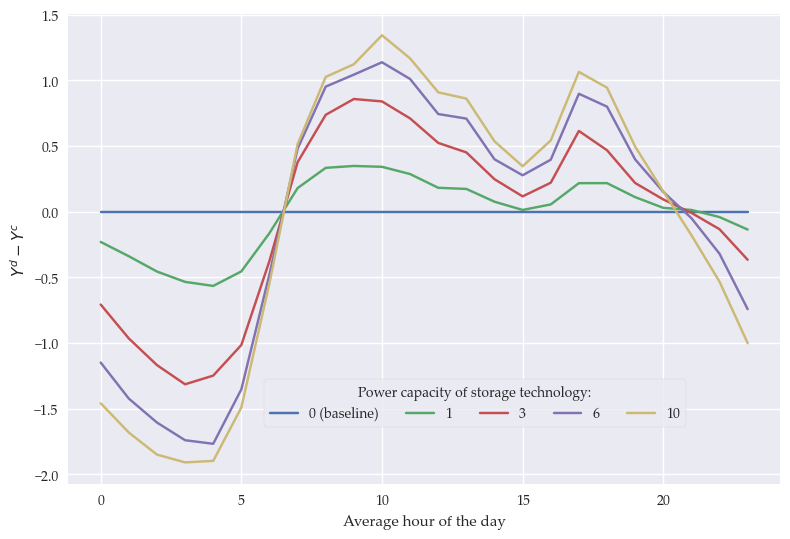

In [ ]:
# Make dataframe
charge = adj.rc_pd(-solution['charge'].droplevel('id'),loop_id).unstack('loop').rename_axis(None,axis=1)
discharge = adj.rc_pd(solution['discharge'].droplevel('id'),loop_id).unstack('loop').rename_axis(None,axis=1)

df_Y =  pd.concat([charge,discharge],axis=0).groupby('h').agg('sum')
df_Y['base'] = 0

# Make new dataframe with time mappings
df = df_Y.reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))

# Make plot
fig, ax = plt.subplots()
df.groupby('HourOfTheDay')[p_names].mean().plot(xlabel='Average hour of the day',ylabel=r'$Y^d-Y^c$',ax=ax,legend=False)
fig.legend(['0 (baseline)']+grid_ECap[loop_id].tolist(),loc='lower center', ncol=len(df_fuelineff.columns), frameon=True, bbox_to_anchor=(0.6,0.2),title=r'Power capacity of storage technology:')
fig.tight_layout()

## E2.5

The cunk of code in the following illustrates the marginal economic value of both power capacity (left) and energy capacity (right) of storage using eq. __(1.4.1.1)__ and __(1.4.2.1)__, respectively.

__Explain why the marginal value of power capacity goes to zero and the marginal value of energy storage is still positive (although also decreasing)__.

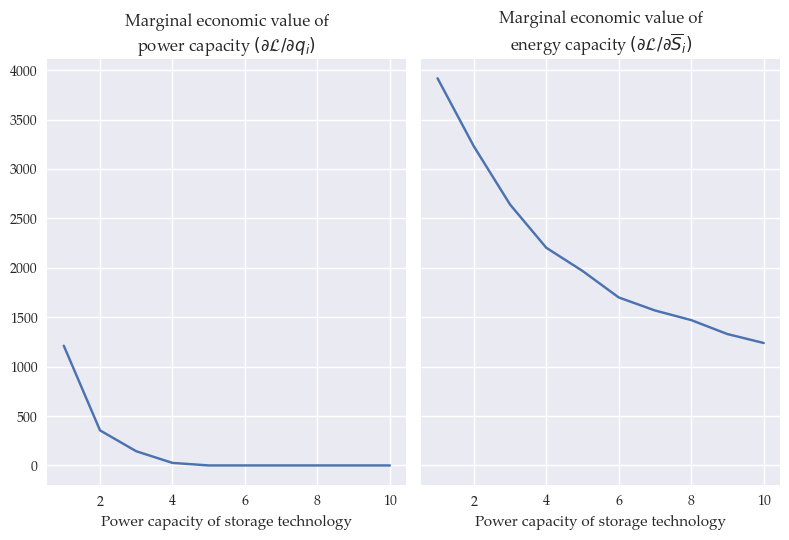

In [ ]:
fig, ax = plt.subplots(ncols=2,sharey=True)
solution['marginalEconomicValue'].xs('idES',level='id').xs('Power',level='CapacityType').iloc[1:].plot(ax=ax[0],title='Marginal economic value of\npower capacity $(\partial \mathcal{L} /\partial q_{i})$',xlabel=r'Power capacity of storage technology')
solution['marginalEconomicValue'].xs('idES',level='id').xs('Energy',level='CapacityType').iloc[1:].plot(ax=ax[1],title='Marginal economic value of\nenergy capacity $(\partial \mathcal{L} /\partial \overline{S}_{i})$',xlabel=r'Power capacity of storage technology')
fig.tight_layout()

___
___Answer:___

The marginal economic value of power capacity is decreasing due to the indirect/equilibrium effect identified in eq. __(8)__ in the lecture note on electricity storage: Because the storage technology is eroding oppertunities of price arbitrage, marginally more price arbitration simply lowers the arbitrage opportunity. While this is an equilibrium effect a more conventional interpretation is that the storage technology features diminishing returns to power capacity. This effect implies that there are no short-run profits associated with investing in more power capacity above 5 GJ. 

However, we do see that the marginal value of energy storage is still positive. The intuition is that it would be optimal to invest in a storage technology with a longer storage duration than 4 hours. In other words, when the power capacity is at 5 GJ all arbitrage oppertunities within a typical day are eroded, and we would need a technology for long-term storage to take advantage of other price spreads. 

## E2.7

__Explain why total CO$_2$ emissions are increasing as illustrated by the folloing chunk of code:__

<Axes: xlabel='Power capacity of storage', ylabel='Ton CO$_2$'>

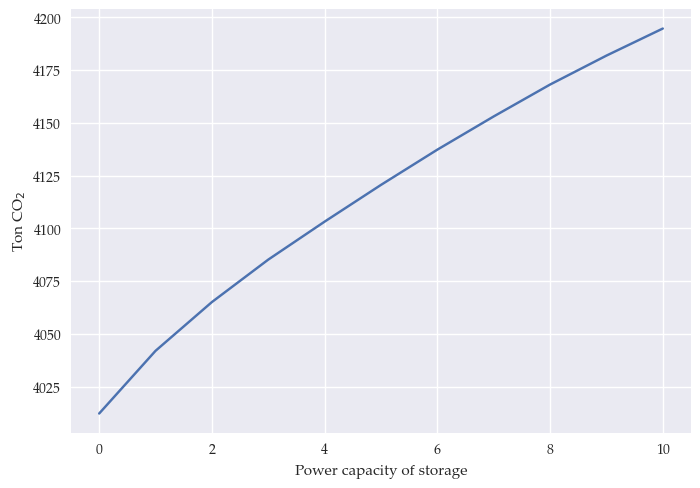

In [ ]:
solution['Emissions'].plot(ylabel='Ton CO$_2$',xlabel='Power capacity of storage')

___
___Answer:___

To answer this question, we need to look at what happens to emission in low-price states vs. high-price states:

<Axes: xlabel='Hour of the day', ylabel='kg CO$_2$'>

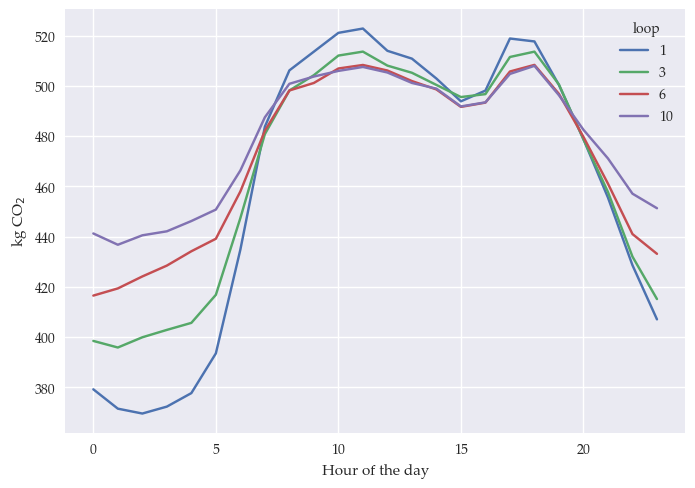

In [ ]:
x = solution['hourlyEmissions'].xs('CO2',level='EmissionType').reset_index().merge(m.db['h2HourOfTheDay'].to_frame(index=False))
adj.rc_pd(x.groupby(['HourOfTheDay','loop'])[0].mean(),loop_id).mul(1000).unstack('loop').plot(ylabel='kg CO$_2$',xlabel='Hour of the day')

While we lowering emissions in high-price states in which stored electricity is dispatch in replacing fossil-based generation, we are crowding in emission in low-price states. Specifically, we are crowding in the coal- and natural-gas fired generators, which increases emissions on net due to their high emission intensity.

# Appendix

The table below translates the names used in the data to the symbols used in the model. 

| Name in excel file | Model symbol |
|:--------|:--------:|
| id | $i$ | 
| BFt | $j$ |
| h | $h$ |
|  FuelMix   |  $\mu_{i,j}$   |
|  GeneratingCapacity   | $q_i$   |
|  OtherMC   | $c_i^{oth}$   |
| FuelPrice | $p_j^f$ |
| EmissionIntensity | $\phi_j$ |
| MWP | $\mu$ |
| LoadVariation $\times$ Load | $D_h$ |
| CapVariation | $\gamma_{i,h} $ |
| sCap | $\overline{S}_i$ |
| effS | $\sqrt{\eta_i}$ |

Note that $c$ is also an index for the consumer type in the data file. In the model in [**Part 1**](#Part-1:-Analytical-Exercises), however, there is only a single representative consumer. But since $c=c1$ always, this is equivalent.

The following section imports the data: